# COMP4211  Tutorial6 : Convolutional Neural Networks 

<p style="text-align: left;">
TA: Issac<br \>
ysunbc@cse.ust.hk<br \>
March 30, 2019 (Mon)<br \>
</p>
<url> https://hkust.zoom.us/j/570617804 </url>

## Outline
1. Load dataset with data augmentation
2. Build CNN classifier
3. train CNN
4. load pre-trained CNN model (VGG16)

# Data Augmentation

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary


In [2]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
image, label = dataset[1]

Files already downloaded and verified


### define different augmentation operation


In [3]:
RandomHorizontalFlip = transforms.Compose([transforms.RandomHorizontalFlip(p=0.9)]) 
RandomAffine = transforms.Compose([transforms.RandomAffine(degrees=45)]) 
RandomCrop = transforms.Compose([transforms.RandomCrop(size=30)]) 

# more transform functions can refer to https://pytorch.org/docs/stable/torchvision/transforms.html

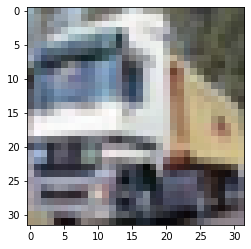

In [4]:
plt.imshow(image)

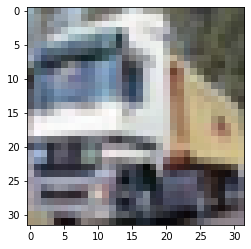

In [5]:
plt.imshow(RandomHorizontalFlip(image))

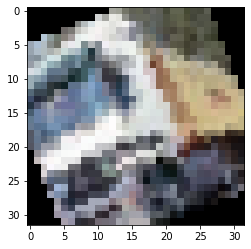

In [6]:
plt.imshow(RandomAffine(image))

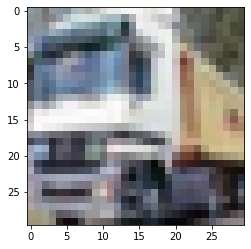

In [7]:
plt.imshow(RandomCrop(image))

# Load Image Dataset

In [8]:
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.RandomHorizontalFlip(p=0.5), # data augmentation by fliping 
     transforms.ToTensor(),    # range [0, 255] -> [0.0,1.0]
     transforms.Normalize((0.5, 0.5, 0.5 ), (0.5, 0.5, 0.5))])   # channel=（channel-mean）/std  -> [-1, 1]


# if the image has only one channel (grayscale), normalise operation will be 
# transforms.Normalize((0.5, ), (0.5, ))

In [9]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

valid_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# To load custom dataset 

# customset = torchvision.datasets.ImageFolder (root='./data' , transform=transform)

# Structure of the image data folder
# root/dog/xxx.png
# root/dog/xxy.png
# root/cat/asd932_.png
# root/pig/ffda.png

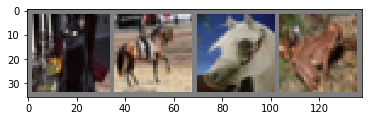

       cat      horse      horse       frog


In [11]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

# Define Convolutional Neural Network

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16,  kernel_size=5)  
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #  3, 32, 32
        # out_dim = in_dim - kernel_size + 1  
        x = self.pool(F.relu(self.conv1(x))) #6, 14, 14 
        x = self.pool(F.relu(self.conv2(x))) #16, 5, 5
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ![Image](./img/dim_cal.png)

In [13]:
model = Net()
summary(model, input_size=(3,32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


# Train model

In [14]:
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'cifar_net.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss



def TRAIN(net, train_loader, valid_loader,  num_epochs, eval_every, total_step, criterion, optimizer, val_loss, device, save_name):
    
    running_loss = 0.0
    running_corrects = 0
    running_num = 0
    global_step = 0
    if val_loss==None:
        best_val_loss = float("Inf")  
    else: 
        best_val_loss=val_loss
    

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs = inputs.to(device)
            labels = labels.to(device)

            '''Training of the model'''
            # Forward pass
            outputs = net(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            global_step += 1

            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
            running_num += len(labels)

            '''Evaluating the model every x steps'''
            if global_step % eval_every == 0:
                with torch.no_grad():
                    net.eval()
                    val_running_loss = 0.0
                    val_running_corrects = 0
                    for val_inputs, val_labels in valid_loader:
                        val_outputs = net(val_inputs)
                        val_loss = criterion(val_outputs, val_labels)
                        _, preds = torch.max(val_outputs.data, 1)
                        val_running_loss += val_loss.item()
                        val_running_corrects += torch.sum(preds == val_labels.data)


                    average_train_loss = running_loss / eval_every
                    average_val_loss = val_running_loss / len(valid_loader)
                    average_train_acc = running_corrects / float(running_num)
                    average_val_acc = val_running_corrects / float(len(valid_loader))

                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f},  Valid Acc: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, total_step, average_train_loss,
                                  average_train_acc, average_val_loss, average_val_acc))

                    running_loss = 0.0
                    running_num = 0
                    running_corrects = 0
                    
                    if average_val_loss < best_val_loss:
                        best_val_loss = average_val_loss
                        save_checkpoint(save_name, net, optimizer, best_val_loss)
                    
                    

    print('Finished Training')

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
num_epochs = 1
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_path = f'cifar_net.pt'
model = model.to(device)

TRAIN(model, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, optimizer, best_val_loss, device, save_path)

Epoch [1/1], Step [1000/12500], Train Loss: 2.0394, Train Acc: 0.2222, Valid Loss: 1.9196,  Valid Acc: 0.2819
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [2000/12500], Train Loss: 1.7675, Train Acc: 0.3383, Valid Loss: 1.6981,  Valid Acc: 0.3842
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [3000/12500], Train Loss: 1.6048, Train Acc: 0.4142, Valid Loss: 1.6545,  Valid Acc: 0.4021
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [4000/12500], Train Loss: 1.5758, Train Acc: 0.4148, Valid Loss: 1.5794,  Valid Acc: 0.4206
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [5000/12500], Train Loss: 1.5342, Train Acc: 0.4295, Valid Loss: 1.6056,  Valid Acc: 0.4258
Epoch [1/1], Step [6000/12500], Train Loss: 1.5039, Train Acc: 0.4523, Valid Loss: 1.4983,  Valid Acc: 0.4475
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [7000/12500], Train Loss: 1.4600, Train Acc: 0.4615, Valid Loss: 1.4259,  Valid Acc: 0.4793
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [8000/12500], Train 

In [17]:
from sklearn.metrics import classification_report


def eval(model, test_loader):
    y_test = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            model.eval()
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.append(predicted.item())
            y_test.append(labels.item())

    print(classification_report(y_test, y_pred))


eval(model, valid_loader)

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1000
           1       0.52      0.83      0.64      1000
           2       0.43      0.35      0.38      1000
           3       0.42      0.29      0.35      1000
           4       0.50      0.43      0.46      1000
           5       0.49      0.45      0.47      1000
           6       0.56      0.64      0.60      1000
           7       0.62      0.62      0.62      1000
           8       0.63      0.68      0.65      1000
           9       0.60      0.46      0.52      1000

    accuracy                           0.54     10000
   macro avg       0.53      0.54      0.53     10000
weighted avg       0.53      0.54      0.53     10000



# Load saved model to continue training 

In [18]:
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.001)


num_epochs = 1
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)
criterion = nn.CrossEntropyLoss()
print(best_val_loss)

TRAIN(load_model, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, load_optimizer, best_val_loss, device, save_path)

Model loaded from <== cifar_net.pt
1.364209078593264
Epoch [1/1], Step [1000/12500], Train Loss: 1.3132, Train Acc: 0.5385, Valid Loss: 1.3400,  Valid Acc: 0.5172
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [2000/12500], Train Loss: 1.3108, Train Acc: 0.5245, Valid Loss: 1.3189,  Valid Acc: 0.5331
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [3000/12500], Train Loss: 1.3181, Train Acc: 0.5293, Valid Loss: 1.2902,  Valid Acc: 0.5390
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [4000/12500], Train Loss: 1.3235, Train Acc: 0.5282, Valid Loss: 1.2617,  Valid Acc: 0.5548
Model saved to ==> cifar_net.pt
Epoch [1/1], Step [5000/12500], Train Loss: 1.2737, Train Acc: 0.5567, Valid Loss: 1.2733,  Valid Acc: 0.5484
Epoch [1/1], Step [6000/12500], Train Loss: 1.2843, Train Acc: 0.5320, Valid Loss: 1.2919,  Valid Acc: 0.5390
Epoch [1/1], Step [7000/12500], Train Loss: 1.2680, Train Acc: 0.5468, Valid Loss: 1.3080,  Valid Acc: 0.5289
Epoch [1/1], Step [8000/12500], Train Loss: 1.261

# Use pretrain model for classification task

# ![Image](./img/vgg16.png)

In [19]:
vgg16 = torchvision.models.vgg16(pretrained=True)

In [20]:
summary(vgg16, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [21]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
for param in vgg16.parameters():
    param.requires_grad = False

### change layer of vgg16


#### method 1

In [23]:
hid_dim = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = torch.nn.Linear(hid_dim, 10)

In [24]:
summary(vgg16, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

#### method 2

In [25]:
class Modified_VGG(nn.Module):

    def __init__(self):
        super(Modified_VGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)
        self.vgg.classifier = nn.Linear(25088, 10)

    def forward(self, images):
        return self.vgg(images)

In [26]:
modified_vgg = Modified_VGG()
summary(modified_vgg, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

#### method 3

In [27]:
vgg_16 = torchvision.models.vgg16(pretrained=True)
hid_dim = vgg_16.classifier[-1].in_features
features = list(vgg_16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(hid_dim, len(classes))]) # Add our layer with 4 outputs
vgg_16.classifier = nn.Sequential(*features) # Replace the model classifier

In [28]:
summary(vgg_16, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

### Train modified vgg16 model

In [ ]:
eval_every = 1000
num_epochs = 1
vgg16_optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

total_step = len(train_loader)*num_epochs
best_val_loss = None
criterion = nn.CrossEntropyLoss()

TRAIN(vgg16, train_loader, valid_loader, num_epochs, eval_every, total_step, criterion, vgg16_optimizer, best_val_loss, device, save_name=None)

Epoch [1/1], Step [1000/12500], Train Loss: 1.6710, Train Acc: 0.4110, Valid Loss: 1.3464,  Valid Acc: 0.5415
Epoch [1/1], Step [2000/12500], Train Loss: 1.4139, Train Acc: 0.5065, Valid Loss: 1.2575,  Valid Acc: 0.5710


### for other pretrained models, please refer to https://pytorch.org/docs/stable/torchvision/models.html